# Introduction


Simply testing if we can use the data to calculate the neerslagtekort


# Initialize the package

First load the modules we will use

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd   
from openkmi.point_obs import Synop
import numpy as np
import pyeto
from pyeto import fao

Then initialize the package

In [2]:
kmi = Synop()

In [3]:
kmi.get_stations()

,code,the_geom,altitude,name,date_begin,date_end
0,6490,POINT (50.478615 5.909864),482.0,SPA (AERODROME),1952-01-01T00:00:00,NaN
1,6476,POINT (50.038875 5.403753),557.0,SAINT-HUBERT,1952-01-01T00:00:00,NaN
2,6414,POINT (50.90398 3.121692),24.8,BEITEM,2003-08-01T07:00:00,NaN
3,6418,POINT (51.347375 3.201846),12.1,ZEEBRUGGE,2005-12-01T00:00:00,NaN
4,6438,POINT (51.324802 4.363798),4.0,STABROEK,2012-08-05T00:00:00,NaN
5,6446,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2001-08-23T00:00:00,2003-12-09T08:00:00
6,6447,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2003-12-01T00:00:00,NaN
7,6477,POINT (50.915458 5.450296),39.3,DIEPENBEEK,2004-06-29T00:00:00,NaN
8,6478,POINT (50.645282 5.458738),178.0,BIERSET,1952-01-01T00:00:00,NaN
9,6439,POINT (51.075125 4.524608),8.3,SINT-KATELIJNE-WAVER,2007-10-22T00:00:00,NaN


# Neerslag afhalen

In [4]:
from owslib.fes import PropertyIsEqualTo
custom_filt = PropertyIsEqualTo(propertyname='precip_range', literal='2')
df_r = kmi.get_data('6447', start_date='1950-01-01T00:00:00', end_date= '2022-07-05T00:00:00',
                    parameter_list=['precip_quantity'], custom_filter=custom_filt)
df_r = df_r[df_r.index.hour.isin([6,18])]

In [5]:
df_r = df_r.resample('d').sum()
df_r.loc[df_r['precip_quantity'] > 100, 'precip_quantity']= 0

# Calculate Penman

https://www.fao.org/3/x0490e/x0490e08.htm#TopOfPage
https://pyeto.readthedocs.io/en/latest/

In [6]:
df = kmi.get_data('6447', start_date='1950-01-01T00:00:00', end_date= '2022-07-05T00:00:00',
                    parameter_list=['temp', 'humidity_relative', 'wind_speed', 'sun_duration_24hours', 'pressure', 'short_wave_from_sky_24hours'])

In [7]:
df_d = df.resample('d').mean()[['temp', 'wind_speed', 'sun_duration_24hours']]

In [8]:
df_d['tmin'] = df.resample('d').min()['temp']
df_d['tmax'] = df.resample('d').max()['temp']
df_d['rh_min'] = df.resample('d').min()['humidity_relative']
df_d['rh_max'] = df.resample('d').max()['humidity_relative']

In [9]:
df_d['sun_duration_24hours'] = df_d['sun_duration_24hours'] / 60
df_d['doy'] = df_d.index.dayofyear

In [10]:
df_d.describe()

,temp,wind_speed,sun_duration_24hours,tmin,tmax,rh_min,rh_max,doy
count,25749.000000,25606.000000,2742.000000,25749.000000,25749.000000,17318.000000,17318.000000,25753.000000
mean,10.365050,3.467169,4.525912,7.280065,13.640200,61.629043,93.075598,182.481381
std,6.391246,1.604229,4.275730,5.772125,7.345349,16.647686,7.497890,105.435917
min,-13.875000,0.000000,0.000000,-16.200000,-12.000000,6.409500,41.500000,1.000000
25%,5.691667,2.312500,0.400000,3.000000,8.000000,49.363400,90.200000,91.000000
50%,10.529167,3.187500,3.525000,7.700000,13.800000,61.900000,94.130850,182.000000
75%,15.250000,4.344365,7.729167,12.000000,19.000000,74.600000,100.000000,274.000000
max,29.975000,15.444444,14.800000,23.700000,39.500000,100.000000,158.387700,366.000000


# With library

In [11]:
def get_montheith_evp(tmin, tmax, rh_min, rh_max, tmean, sunshine_hours, day_of_year, ws, altitude=100):
    svp_tmin = pyeto.svp_from_t(tmin)
    svp_tmax = pyeto.svp_from_t(tmax)
    if not np.isnan(rh_max) and not np.isnan(rh_max):
        ea = pyeto.avp_from_rhmin_rhmax(svp_tmin, svp_tmax, rh_min, rh_max)
    else:
        ea = pyeto.avp_from_tmin(tmin)
    es = pyeto.mean_svp(tmin, tmax)
    sol_dec = pyeto.sol_dec(day_of_year)
    sha = pyeto.sunset_hour_angle(pyeto.deg2rad(50.48), sol_dec)
    daylight_hours = pyeto.daylight_hours(sha)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    et_rad = pyeto.et_rad(pyeto.deg2rad(50.48), sol_dec, sha, ird)
    cs_rad = pyeto.cs_rad(pyeto.deg2rad(50.48), et_rad)
    if not np.isnan(sunshine_hours):
        sol_rad = pyeto.sol_rad_from_sun_hours(daylight_hours, sunshine_hours, et_rad)
    else:
        sol_rad = pyeto.sol_rad_from_t(et_rad, cs_rad, tmin, tmax, False)
    ni_sw_rad = pyeto.net_in_sol_rad(sol_rad, albedo=0.23)
    no_lw_rad = pyeto.net_out_lw_rad(tmin +273.16, tmax +273.16, sol_rad, cs_rad, ea)
    net_rad = pyeto.net_rad(ni_sw_rad, no_lw_rad)
    delta_svp = pyeto.delta_svp(tmean)
    psy = pyeto.psy_const(pyeto.atm_pressure(altitude))
    return float(pyeto.fao56_penman_monteith(net_rad, tmean+273.16, ws, es, ea, delta_svp, psy, shf=0.0))

In [12]:
# Test for function based on example in FAO manual
rh_max = 84
rh_min = 63
tmin = 12.3
tmax = 21.5
tmean = 16.9
sunshine_hours = 9.25
day_of_year = 187
altitude = 100
ws = 2.078

get_montheith_evp(tmin, tmax, rh_min, rh_max, tmean, sunshine_hours, day_of_year, ws)

3.882280344497788

In [13]:
df_d['evp'] = None
# Apply better but we're just testing now
for i in df_d.index:
    df_d.loc[i, 'evp'] = get_montheith_evp(df_d.loc[i, 'tmin'], df_d.loc[i, 'tmax'], df_d.loc[i, 'rh_min'], df_d.loc[i, 'rh_max'], df_d.loc[i, 'temp'], 
                                           df_d.loc[i, 'sun_duration_24hours'], df_d.loc[i, 'doy'], df_d.loc[i, 'wind_speed'])

In [14]:
# fill the missing values
df_d['evp'] = df_d['evp'].fillna(method='ffill')

In [15]:
df_f = df_r.join(df_d['evp'])

<AxesSubplot:xlabel='timestamp'>

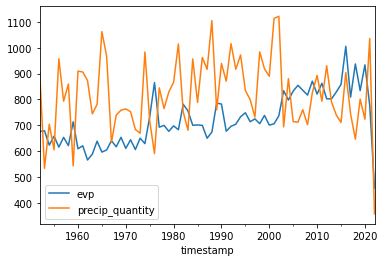

In [16]:
df_f.resample('y').sum()[['evp', 'precip_quantity']].plot()

In [17]:
df_f['neerslagtekort'] = df_f['evp'] - df_f['precip_quantity']

<AxesSubplot:xlabel='timestamp'>

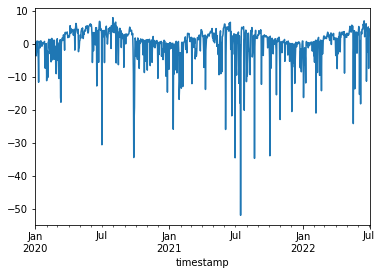

In [18]:
df_f['neerslagtekort'].truncate(before='2020-01-01').plot()

Note that there seem to be some rather high and unrealistic values in the graph. Therefore we quickly check the number of datapoints for each year in the plot below.

In [19]:
df_f['year'] = df_d.index.year
df_f['doy'] = df_d.index.dayofyear

In [20]:
df_dd = df_f.pivot(index='doy', columns='year', values='neerslagtekort')

Text(0.5, 0, 'Dag van het jaar')

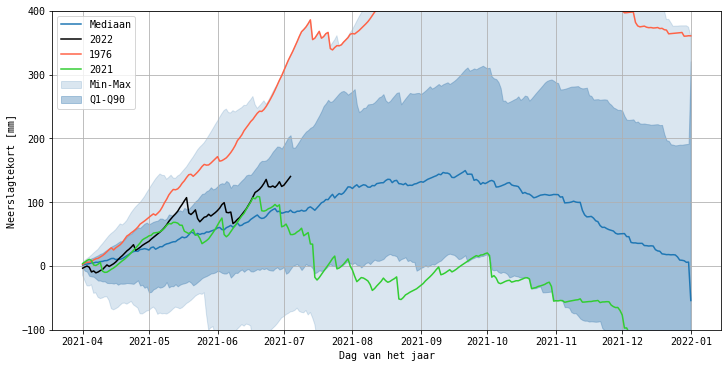

In [21]:
import datetime

plt.rcParams['font.family'] = 'MonoSpace'

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)

trunc = 91
xas = [datetime.datetime(2021, 1, 1) + datetime.timedelta(x - 1) for x in df_dd.index]
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().min(axis=1), df_dd.truncate(before=trunc).cumsum().max(axis=1), alpha=.2, color='steelblue')
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.1, axis=1), df_dd.truncate(before=trunc).cumsum().quantile(.9, axis=1), color='steelblue', alpha=.4)
ax.plot(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.5, axis=1))
ax.plot(xas[trunc-1:], df_dd[2022].truncate(before=trunc).cumsum(),  color='black')
ax.plot(xas[trunc-1:], df_dd[1976].truncate(before=trunc).cumsum(),  color='tomato')
ax.plot(xas[trunc-1:], df_dd[2021].truncate(before=trunc).cumsum(),  color='limegreen')
ax.grid()
ax.set_ylim([-100,400])
ax.legend(['Mediaan', '2022', '1976', '2021', 'Min-Max', 'Q1-Q90'], loc=2)
ax.set_ylabel('Neerslagtekort [mm]')
ax.set_xlabel('Dag van het jaar')